# T_Matrix-Spectral_Analysis

# (Stage 3): Statistical Analysis of Translation Spectra 
In Stage 3 we extract the spectra of the translation matrices and find statistical properties of the spectra.

### Stage 3 steps:
1. Read in all translation matrices generated and exported as csv files in Stage 2
2. Calculate the spectral values and the log of the spectral values for:
    1. the raw translation matrix
    2. the covariance matrix of the translation matrix (optional)
3. Calculate statistical properties of the respective spectra (mean, max, min, median, std)
4. Export the resulting statistics as a json to:
    * `../data/l2=0_01_normality=0_000001/spec_analysis_stats.json`

Stage 3 is fully executed by running the following python script 
* `execute_spectral_analysis.py`
* The `../data/l2=0_01_normality=0_000001/` argument specifies the relative path to the T_matrices directory with the csv files exported in stage 2.

In [1]:
!python execute_spectral_analysis.py ../data/l2=0_01_normality=0_000001/

Using TensorFlow backend.
6100.90710561 3.78539441233
37221067.5182 7.57078882475
42304.5546895 4.6263871279
1789675351.36 9.25277425673
14693.8808484 4.16713651386
215910134.421 8.33427302779
21575.0171449 4.33395114951
465481365.013 8.66790229921
13642.5779907 4.1348964452
186119934.414 8.26979289082
35004.6195905 4.54412536236
1225323394.31 9.0882507253
66279.544305 4.82137951383
4392978070.92 9.64275903534
10391.0272433 4.01665848346
107973447.246 8.03331696722
399.59426532 2.60161924693
159675.576877 5.20323849385
51770.9853082 4.71408643058
2680234949.93 9.42817286604
75357.2255862 4.87712490074
5678711524.76 9.75424980734
10202.4922482 4.00870627347
104090848.11 8.01741254709
38208.28414 4.5821575348
1459872980.19 9.16431507058
27767.0601449 4.44352990098
771009631.72 8.88705980344
33842.6721166 4.52946464632
1145326462.03 9.05892929493
23989.6024242 4.38002305054
575501025.995 8.76004610222
343.286402643 2.53565660164
117845.554239 5.07131320327
11193.1303214 4.04895156027
1252

# (Stage 4): Plot Heatmaps of Spectra Statistics 

### Stage 4 steps:
1. Read in the json containing the statistical properties of the spectra calculated in stage 3, 
2. Plot as a heatmap grid the respective statistics associated with each translation.
    * The grid represents the translations from each language (row) to each other language (column).
    * Diagonals on the grid correspond to baselines for when a language is translated to itself.
    * Each heatmap is generated from 
        * a matrix type (translation matrix or or its covariance matrix), and
        * a different selected statistic.
    
Stage 4 can be executed locally with the following two functions from `ismtools`:
* `read_json` to read the json stats back in as the `T_matrix_dict`
* `plot_heatmaps` select which heatmaps you want to generate


mean of the translation matrix spectrum


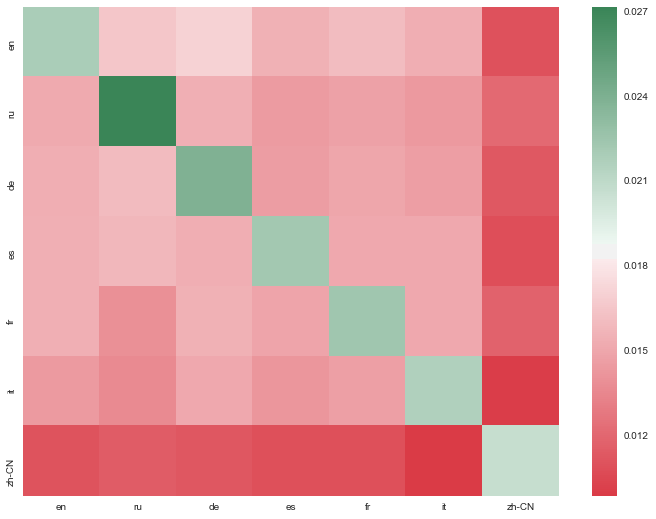

median of the translation matrix spectrum


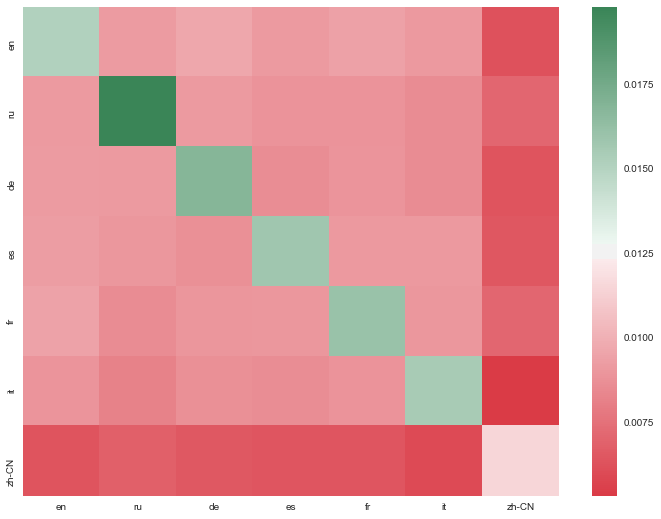

std of the translation matrix spectrum


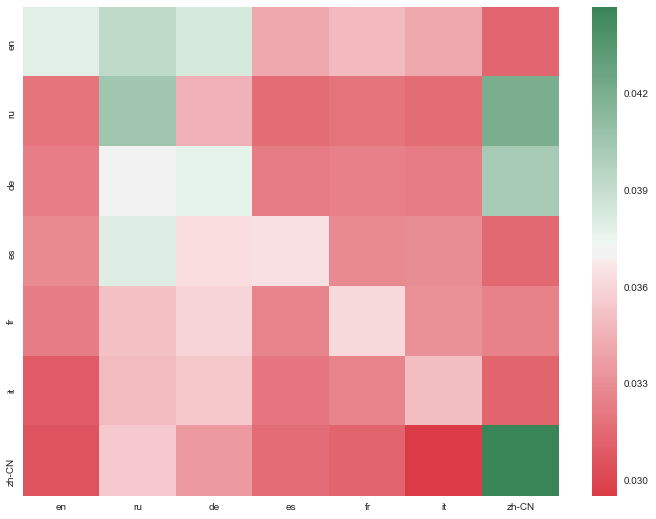

mean_log of the translation matrix spectrum


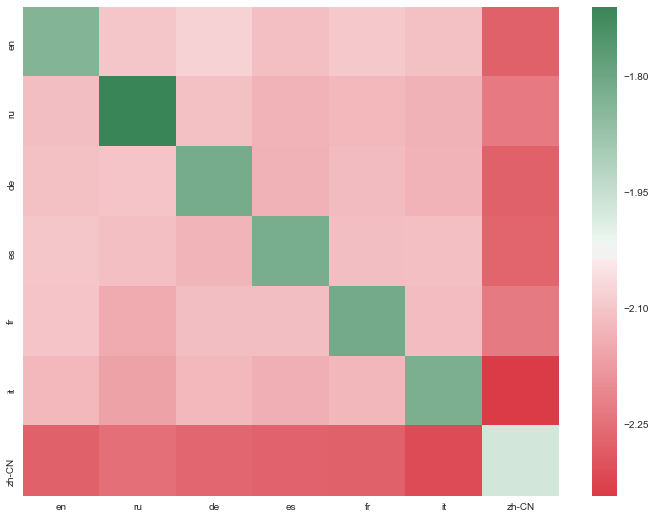

median_log of the translation matrix spectrum


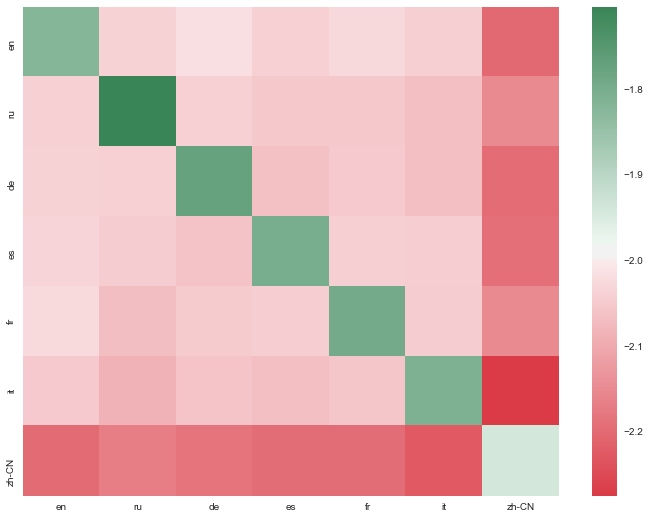

std_log of the translation matrix spectrum


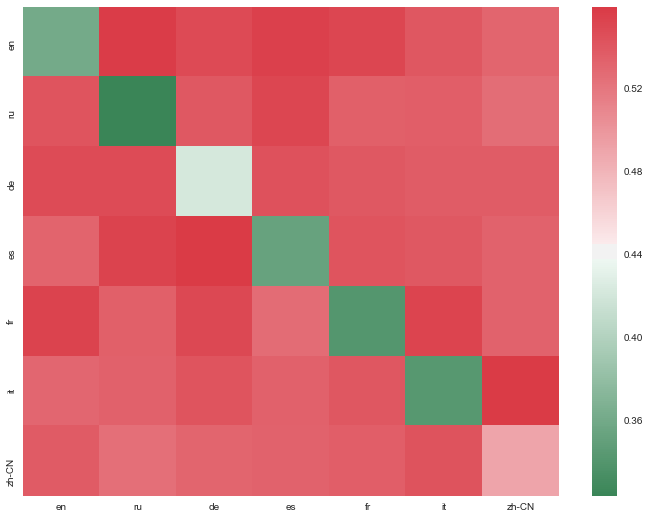

ortho_norm of the translation matrix spectrum


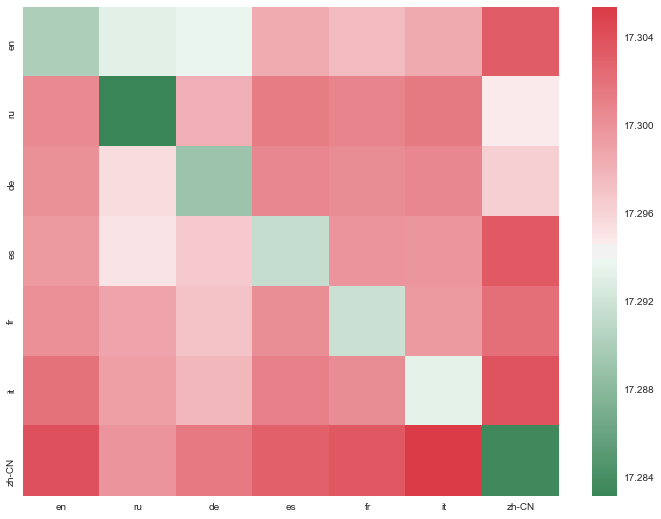

condition_num of the translation matrix spectrum


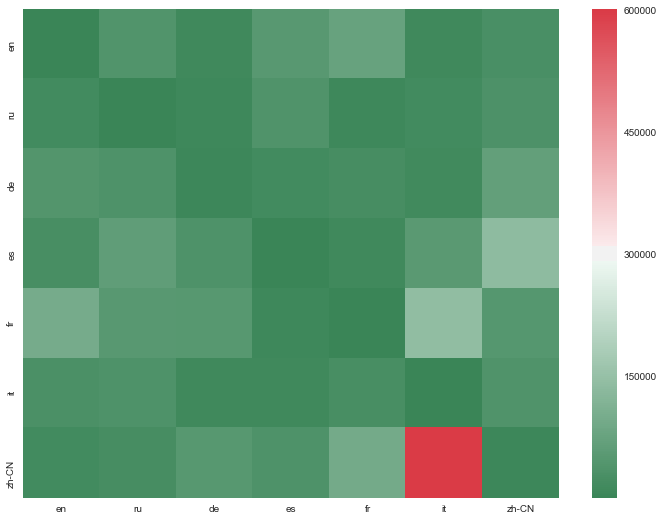

log_condition_num of the translation matrix spectrum


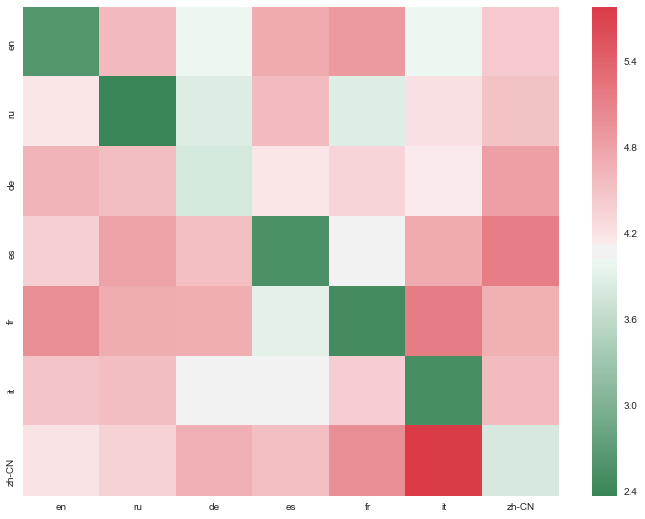

mean of the translation covariance matrix spectrum


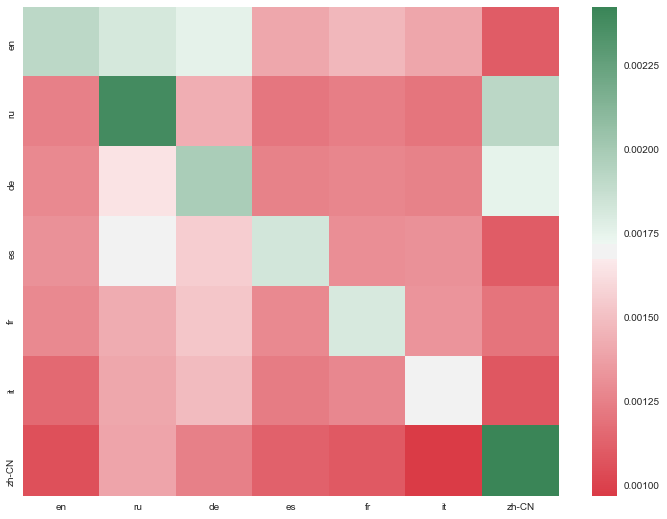

median of the translation covariance matrix spectrum


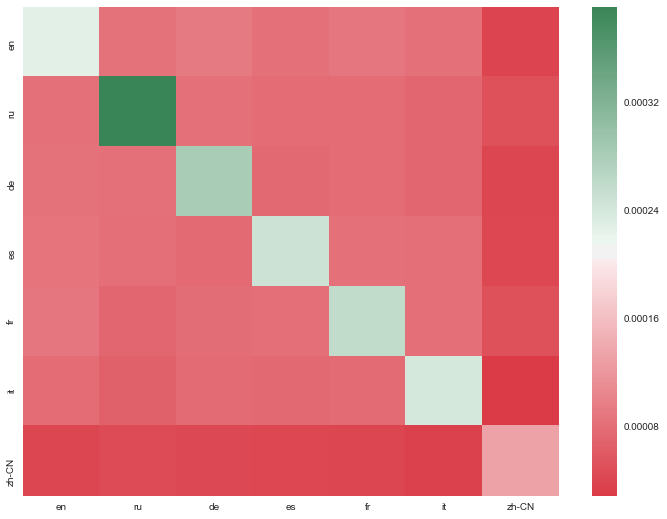

std of the translation covariance matrix spectrum


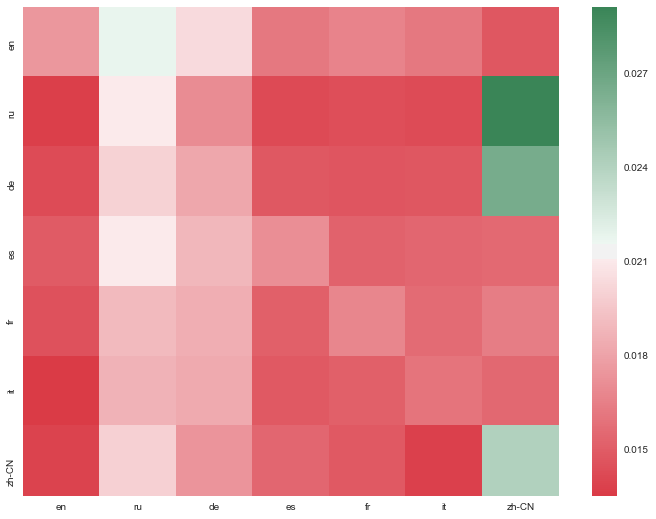

mean_log of the translation covariance matrix spectrum


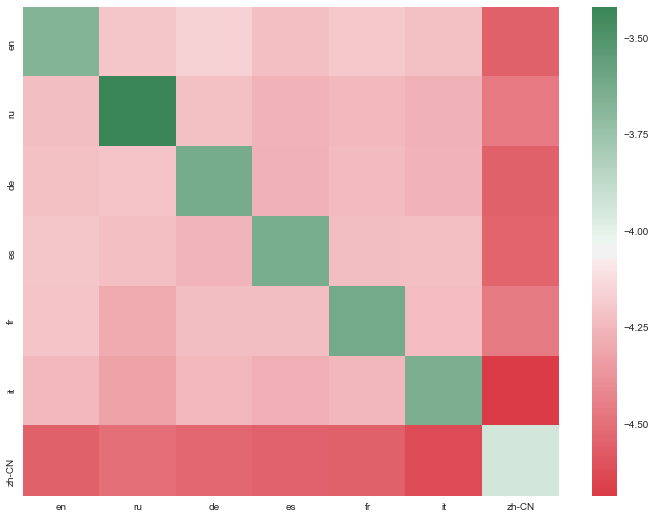

median_log of the translation covariance matrix spectrum


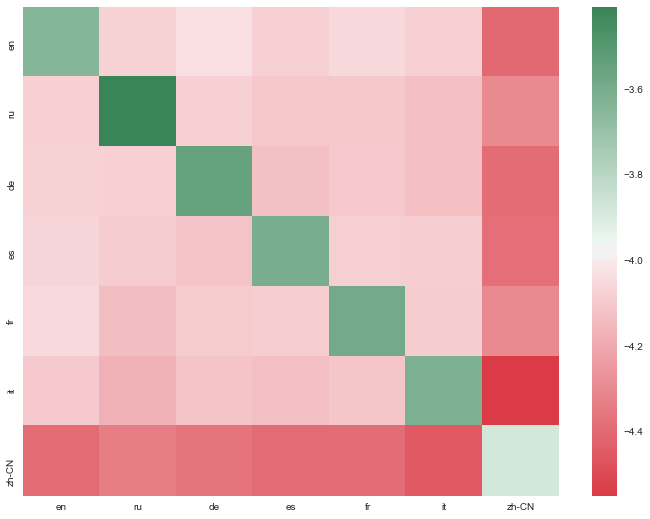

std_log of the translation covariance matrix spectrum


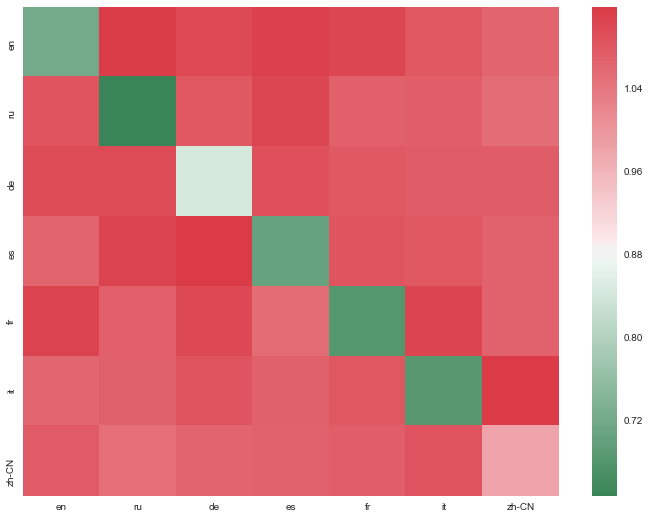

ortho_norm of the translation covariance matrix spectrum


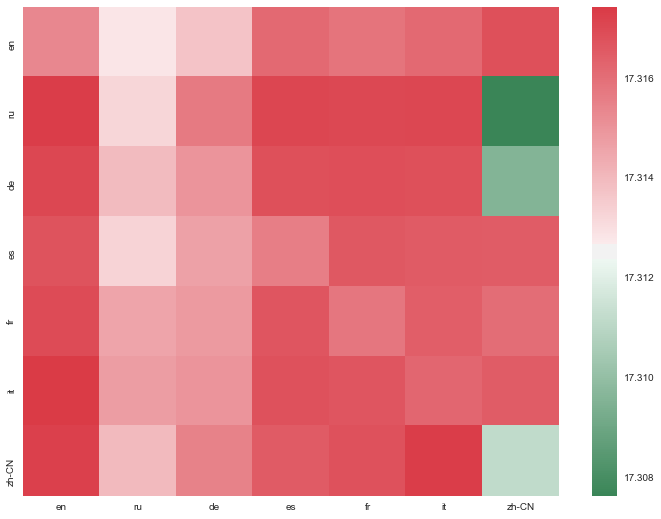

condition_num of the translation covariance matrix spectrum


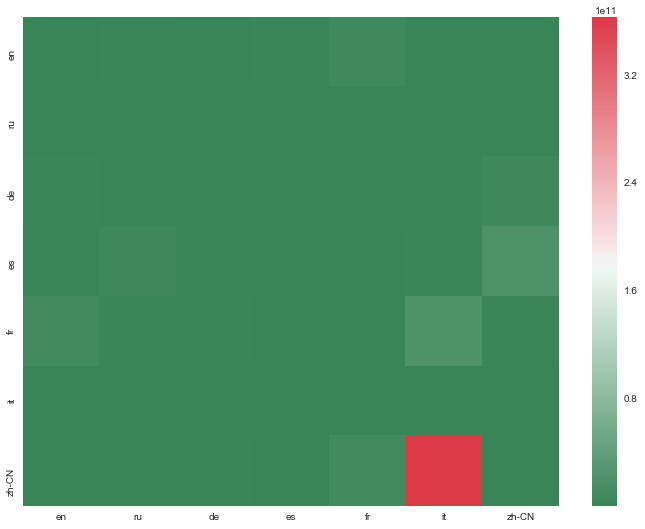

log_condition_num of the translation covariance matrix spectrum


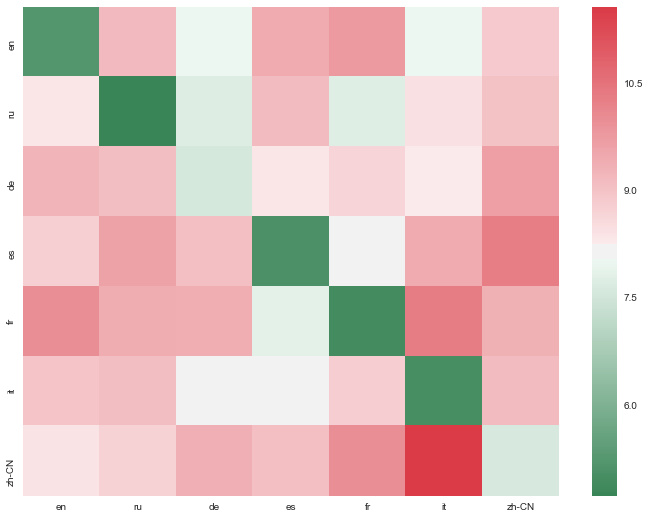

In [10]:
from ismtools import read_json, plot_heatmaps
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


JSON_PATH = "../data/l2=0_01_normality=0_000001/spec_analysis_stats.json"
MATRIX_TYPES = ["T_matrix", "T_cov"]
STATS = [
         'mean', 
         'median', 
         'std', 
         'mean_log', 
         'median_log', 
         'std_log', 
         'ortho_norm',
         'condition_num',
         'log_condition_num',
#          'determinant'
        ]


heatmaps = plot_heatmaps(T_matrix_dict=read_json(JSON_PATH),
                         plotted_stats=STATS,
                         display_opt="cols",
                         matrix_types=MATRIX_TYPES,
                         low_c=10,
                         high_c=140,
                         sep_num=8,
                         figuresize=[12,9]
                        )